## Simulating an IA that learns incrementally
An IA can incrementally gain experience and improve performance much like a human agent. In this process of a call center answering user questions, the topic of the question can be determined by an **IA** based on the user click stream data.

The *resource characteristics* of the IA is the **performance** that improves with time as the agent *learns* with more information from data

The **experience** of the agent further increases


In [89]:
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams


from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
import pandas as pd

In [90]:
#read the csv file and create a dataframe

train_data = pd.read_csv("resources/question_click.csv", sep=",")
train_data['date'] = pd.to_datetime(train_data['date'])
all_classes = train_data['qtheme'].unique()
train_data.head(5)

#print(all_classes)

,sessionID,page_name,customerID,ageCategory,gender,date,qtheme,qsubtheme,qtopic
0,31276103,taken,1170218,40-49,M,2015-09-02,41,28370,28460
1,29687625,mijn_berichten,2024531,18-29,M,2015-08-26,41,28380,28898
2,14143796,taken,1928524,40-49,M,2015-08-31,41,28377,28503
3,5977596,wijziging_doorgeven,2018842,50-65,V,2015-08-25,41,28375,7778
4,24071002,home,1400900,18-29,M,2015-09-01,25658,25518,25572


### Extracting relevant information from event log (features) 
Transform the event log using the one-hot encoding and aggregating session clicks for each customer and session. 

In [91]:
def transform(X, col_names, label_col):
        
   # transform cat cols
    dt_transformed = pd.get_dummies(X[col_names])
    dt_transformed['sessionID'] = X['sessionID']
    dt_label = X.groupby('sessionID').first()[label_col]
    del X
    dt_transformed = dt_transformed.groupby('sessionID').sum()
    
    dt_transformed = dt_transformed.fillna(0)
    #print(dt_transformed)
    return dt_transformed, dt_label
    

### Chunking the data based on time to reflect new data processed by IA
We first split the data multiple chunks. The last chunk is used as a **unseen data** and the remaining are incrementally added to train the classifier.


The **unseen data** is used later to present an **online** scenario where the agent characteristics would be used to decide the level of automation.

In [115]:
dt_x, dt_y = transform(train_data, ['page_name', 'ageCategory', 'gender'], 'qtheme')
#print(dt_x)

data_xdict = dict()
for g, df in dt_x.groupby(np.arange(len(dt_x)) // 200):
    data_xdict[g]=df

data_ydict = dict()
for g, df in dt_y.groupby(np.arange(len(dt_y)) // 200):
    data_ydict[g]=df

for key in data_xdict.keys():
    print(key, data_xdict[key].shape, data_ydict[key].shape)
    
#print(data)


0 (200, 27) (200,)
1 (200, 27) (200,)
2 (200, 27) (200,)
3 (200, 27) (200,)
4 (200, 27) (200,)
5 (200, 27) (200,)
6 (36, 27) (36,)


### Prepare the data for the machine learning classifier


In [116]:
partial_fit_classifiers = {
    'Perceptron': Perceptron()
}

### Train the machine learning model
1. The data is split into train and test 
2. First hyper parameter tuning is done using grid search and cross validation (4-fold)
3. The classifier performance is evaluated on the test set

In [117]:
num_batches = len(data_xdict)-2
print(num_batches)
accuracy_dict=dict()

X_test = data_xdict[num_batches-1]
y_test = data_ydict[num_batches-1]

total_vect_time=0

for i in range(0,num_batches):

    tick = time.time()
    X_train = data_xdict[i]
    y_train = data_ydict[i]
    total_vect_time += time.time() - tick

    for cls_name, cls in partial_fit_classifiers.items():
        tick = time.time()
        # update estimator with examples in the current mini-batch
        cls.partial_fit(X_train, y_train, classes=all_classes)

        # accumulate test accuracy stats
        accuracy = cls.score(X_test, y_test)
        if cls_name in accuracy_dict:
            lst = accuracy_dict[cls_name]
            lst.append(accuracy)
            accuracy_dict[cls_name]= lst
        else:
            accuracy_dict[cls_name]=[accuracy]
        print( 'accuracy of ', cls_name, ' in iteration ', i , " = ", accuracy)




5
accuracy of  Perceptron  in iteration  0  =  0.865
accuracy of  Perceptron  in iteration  1  =  0.96
accuracy of  Perceptron  in iteration  2  =  0.94
accuracy of  Perceptron  in iteration  3  =  0.965
accuracy of  Perceptron  in iteration  4  =  0.965


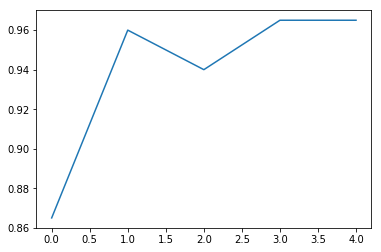

In [118]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes()

for cls_name in accuracy_dict.keys():
    ax.plot(accuracy_dict[cls_name]);

### Evaluating resource characteristic on unseen data
